# Mesh resolution

In [ ]:
from lucifex.solver import OptionsPETSc
from lucifex.fdm import AB, CN
from lucifex.sim import run, Simulation
from lucifex.viz import plot_colormap, plot_line
from lucifex.utils import as_index
from crocodil.dns import dns_system_a, SYSTEM_A_REFERENCE

STORE = 1
CELL_TYPE = 'quadrilateral'

def create_simulation(
    Nx,
    Ny,
    cell,
):
    return dns_system_a(
        store_delta=STORE, 
    )(
        Nx=Nx,
        Ny=Ny,
        cell=cell,
        scaling='advective',
        **SYSTEM_A_REFERENCE,
        D_adv=AB(1)@CN,
        D_diff=AB(1)@CN,
        dt_max=0.1,
        cfl_courant=0.5,
        c_stabilization=None,
        c_limits=None,
        c_petsc=OptionsPETSc('gmres', 'ilu'),
        flow_petsc=(OptionsPETSc('cg', 'hypre'), None),
        diagnostic=True,
    )


NxNy_opts = ((60, 60), (120, 60), (120, 120), (160, 120), (160, 160), (160, 160), (180, 180))
simulations: dict[tuple[int, int], Simulation] = {}

for Nx, Ny in NxNy_opts:
    simulations[(Nx, Ny)] = create_simulation(Nx, Ny, CELL_TYPE)

n_stop = 100
t_stop = 12.0
dt_init = 1e-6
n_init = 10
for NxNy in NxNy_opts:
    sim = simulations[NxNy]
    run(sim, n_stop, t_stop, dt_init=dt_init, n_init=n_init)

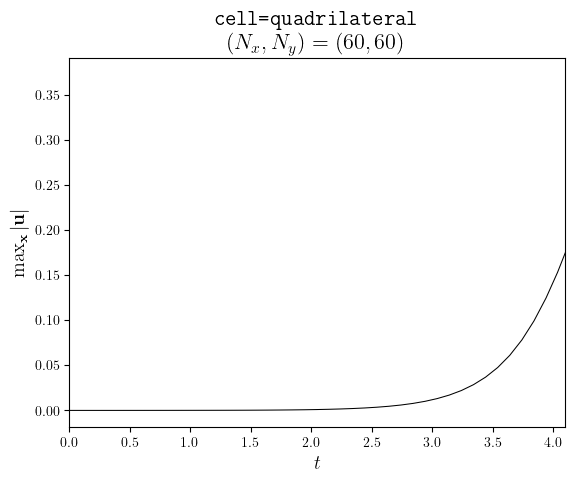

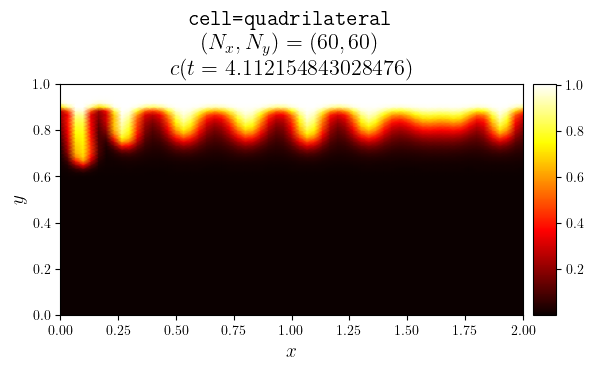

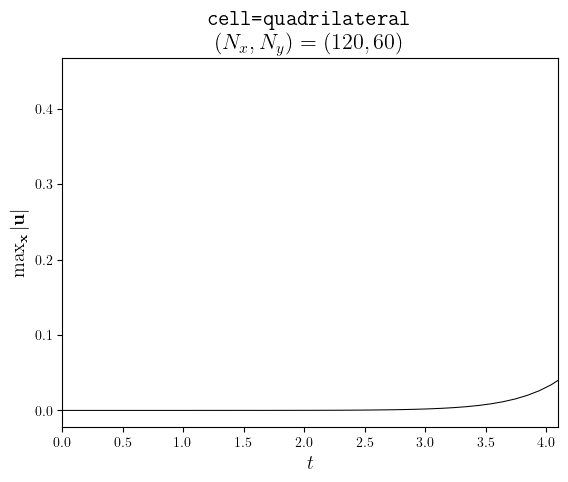

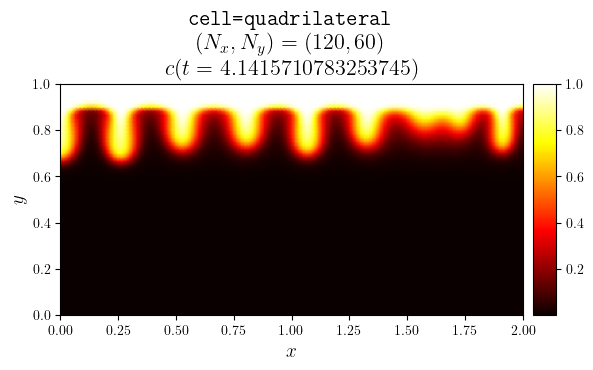

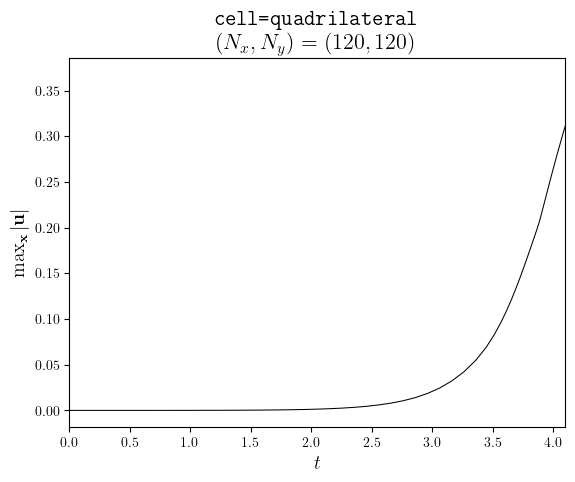

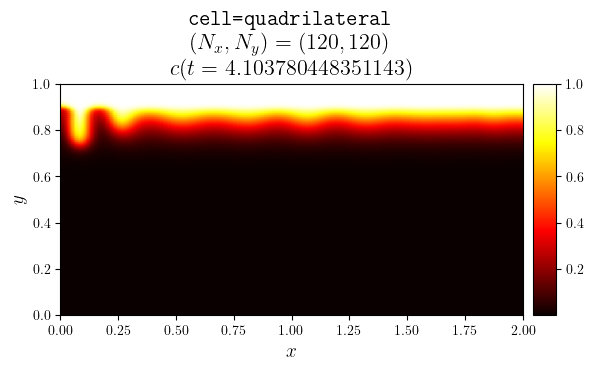

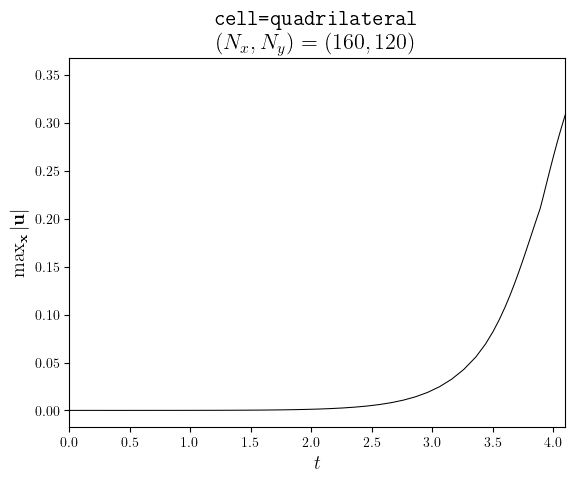

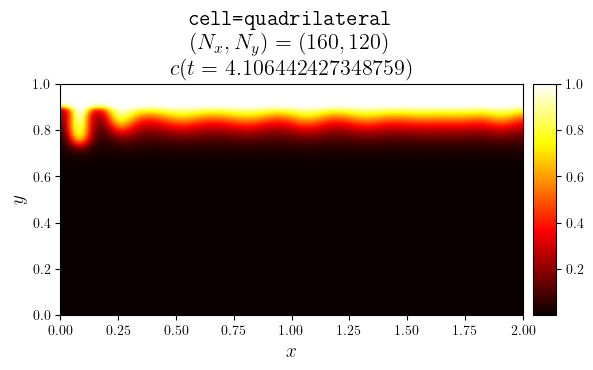

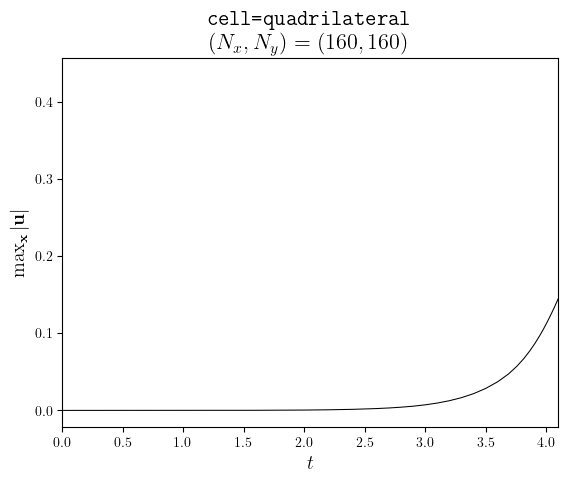

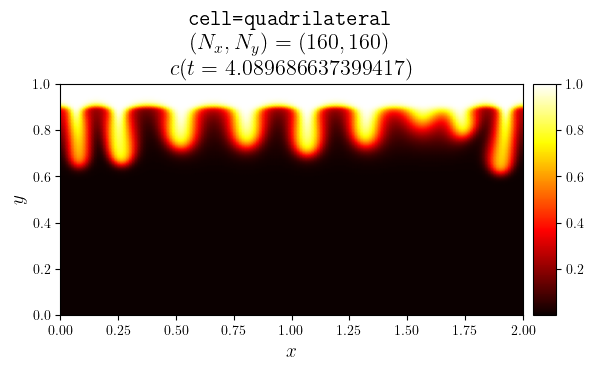

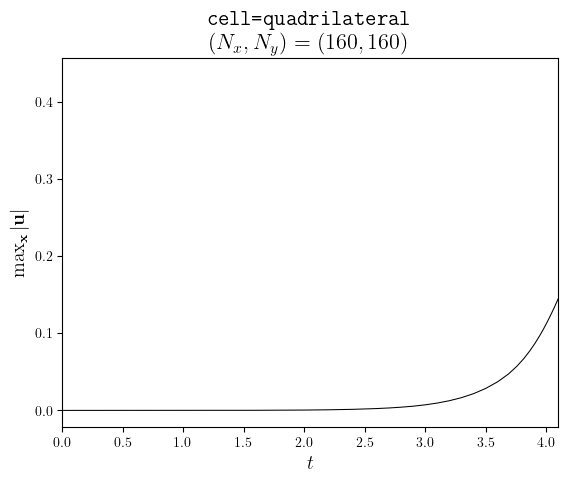

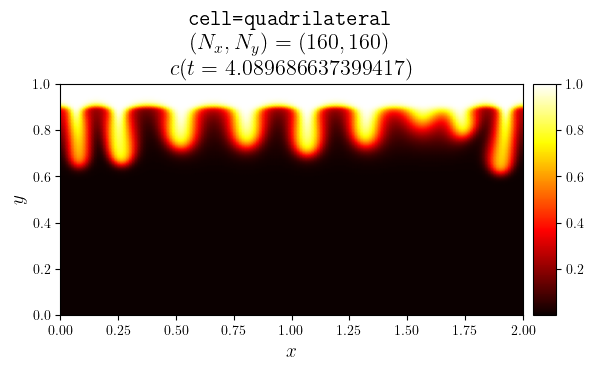

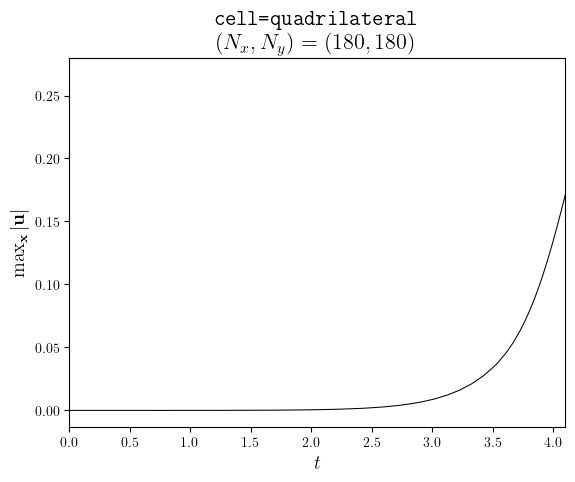

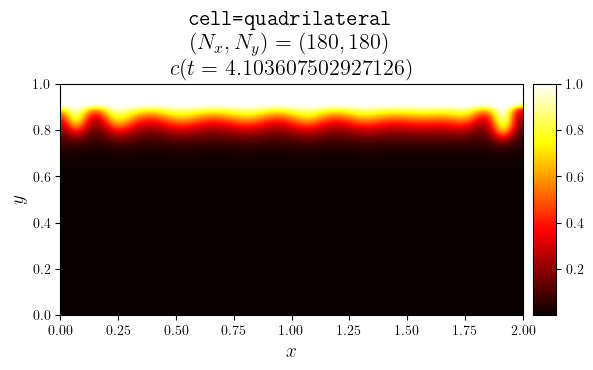

: 

In [ ]:
T_TARGET = 4.1

for Nx, Ny in NxNy_opts:
    title = f'\\texttt{{cell={CELL_TYPE}}}\n $(N_x, N_y)=({Nx}, {Ny})$'
    sim = simulations[(Nx, Ny)]
    uMinMax = sim['uMinMax']
    uMax = uMinMax.sub(1)
    fig, ax = plot_line(
        (uMax.time_series, uMax.value_series),
        x_label='$t$',
        y_label='$\max_{\mathbf{x}}|\mathbf{u}|$',
        x_lims=(0, T_TARGET),
        title=title,
    )
    c = sim['c']
    time_index = as_index(c.time_series, T_TARGET)
    cmap_title = f'{title}\n $c(t={c.time_series[time_index]})$'
    fig, ax = plot_colormap(c.series[-1], title=cmap_title)